Exploring a sample of the [SEN12MS dataset](https://arxiv.org/abs/1906.07789). The code for the data loader is provided by the authors of the paper and the dataset. We only explore the functionality they implemented and look through some of the images.

In [1]:
# in Colab, rasterio needs to be installed
# !pip install rasterio

import random
import pathlib
import numpy as np
import matplotlib.pyplot as plt

# download and extract the dataset sample (I uploaded it to my GDrive)
if not pathlib.Path('SEN12MS_sample').is_dir():
    !gdown --id 1GKHIPhhfjutCbb3LhJ0tgjxDvIuDO7tr
    !tar -zxf SEN12MS_sample.tgz
    !rm SEN12MS_sample.tgz

# this module comes with the dataset and it provides a data loader
import SEN12MS_sample.sen12ms_dataLoader as sen12ms

In [2]:
# the constants that are used for bands/seasons/sensors are defined as enumerations
# in the sen12ms_dataLoader module

sen12ms.S1Bands.ALL  # avaliable options are: VV, VH, ALL, NONE
sen12ms.S2Bands.ALL  # B01 = aerosol, B02 = blue, ..., B12 = swir2, ALL, RGB, NONE
sen12ms.LCBands.ALL  # IGBP, LCCS1, LCCS2, LCCS3, ALL, NONE
sen12ms.Seasons.ALL  # SPRING, SUMMER, FALL, WINTER, ALL

pass

In [3]:
# initialize the data loader
dataset = sen12ms.SEN12MSDataset(base_dir='SEN12MS_sample')

In [4]:
# ids of scenes that are avaliable for tha specified season
# (I only uploaded 1 from each season, because they are massive)
scene_ids = dataset.get_scene_ids(season=sen12ms.Seasons.SUMMER)
print(type(scene_ids), scene_ids)

<class 'set'> {4}


In [5]:
# ids of the patches that are extraxted from the specified scene
patch_ids = dataset.get_patch_ids(season=sen12ms.Seasons.SUMMER, scene_id=4)
print(type(patch_ids), f'length: {len(patch_ids)}')
print(f'First 10 values: {patch_ids[:10]}')

<class 'list'> length: 740
First 10 values: [691, 742, 660, 185, 697, 632, 590, 482, 79, 411]


In [6]:
bands = sen12ms.S2Bands.RGB
data, bounds = dataset.get_patch(season=sen12ms.Seasons.SUMMER, scene_id=4, patch_id=79, bands=bands)

print(type(data), f'shape: {data.shape}')
print(type(bounds), f'left bound: {bounds.left}\n')

<class 'numpy.ndarray'> shape: (3, 256, 256)
<class 'rasterio.coords.BoundingBox'> left bound: 443503.59640957054



In [7]:
def get_false_color_s1_image(s1_data):
    """ Generate a VV/VH/R false color image to plot with matplotlib. """
    
    # add a polarization ratio channel
    image = np.empty(shape=(3,) + s1_data.shape[1:])  # new shape is (3, H, W)
    image[:2, ...] = s1_data                          # the first two channels are the same
    image[2] = s1_data[0] - s1_data[1]                # the data is in dB, so ratio becomes difference

    # normalize channel-wise and swap axes from CHW to HWC
    shifted = image - image.min(axis=(1, 2), keepdims=True)
    spread = image.max(axis=(1, 2), keepdims=True) - image.min(axis=(1, 2), keepdims=True)
    
    image = np.transpose(shifted / spread, [1, 2, 0])
    
    return image

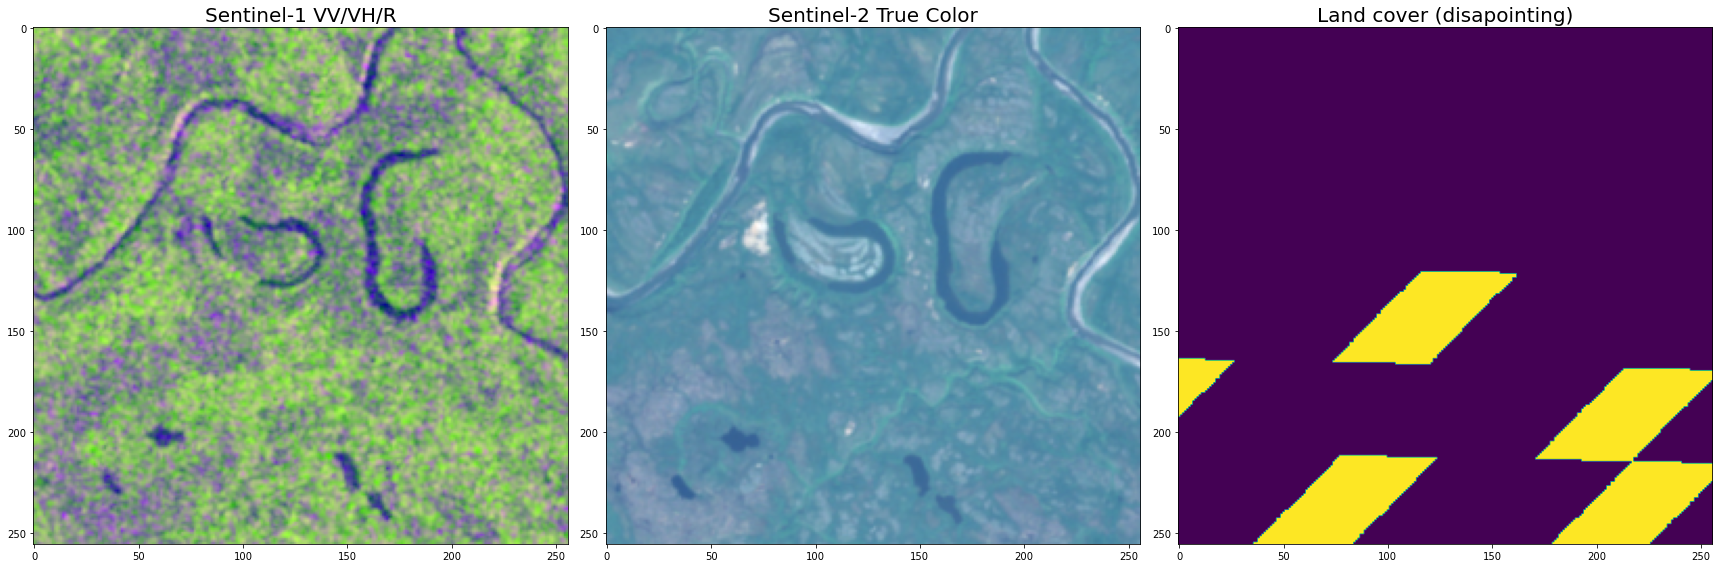

In [8]:
# there is also a function that returns all three. by default,
# it returns all bands, but there are s1_bands, s2_bands, s3_bands arguments
s1, s2, lc, _ = dataset.get_s1s2lc_triplet(sen12ms.Seasons.SUMMER, 4, 79)

s1_image = get_false_color_s1_image(s1)

# normalize channelwise and swap the channels from CHW to HWC
rgb = s2[3:0:-1]
s2_image = np.transpose(rgb / rgb.max(axis=(1, 2), keepdims=True), [1, 2, 0])

# display only one variant of land cover
lc_image = np.squeeze(lc[3])

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(24, 8), tight_layout=True)

ax0.imshow(s1_image, aspect='auto', cmap='binary')
ax1.imshow(s2_image, aspect='auto')
ax2.imshow(lc_image.squeeze(), aspect='auto')

ax0.set_title('Sentinel-1 VV/VH/R', fontsize=20)
ax1.set_title('Sentinel-2 True Color', fontsize=20)
ax2.set_title('Land cover (disapointing)', fontsize=20);

Shape returned from get_triplets: (3, 2, 256, 256) <- a batch



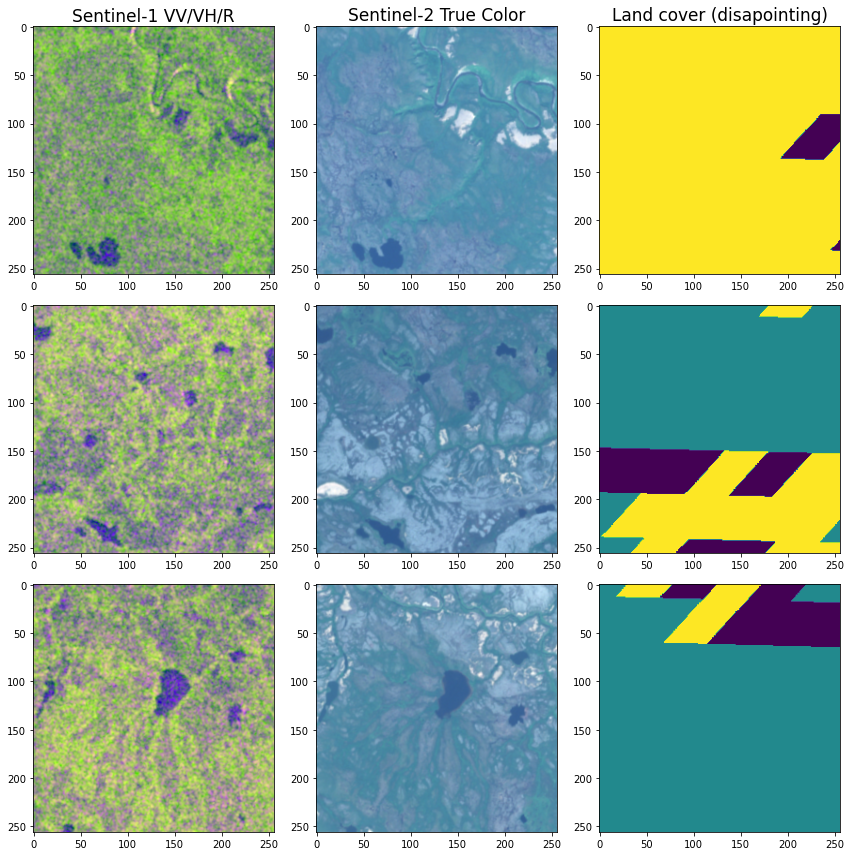

In [9]:
season = sen12ms.Seasons.SUMMER
scene = next(iter(dataset.get_scene_ids(season)))
patch_ids = dataset.get_patch_ids(season, scene)

sample_patches = random.sample(patch_ids, 3)

kwargs = {
    'season': season,
    'scene_ids': scene,
    'patch_ids': sample_patches,
    's1_bands': sen12ms.S1Bands.ALL,
    's2_bands': sen12ms.S2Bands.ALL,
    'lc_bands': sen12ms.LCBands.ALL,
}

s1, s2, lc, _ = dataset.get_triplets(**kwargs)
print(f'Shape returned from get_triplets: {s1.shape} <- a batch\n')


fig, axes = plt.subplots(3, 3, figsize=(12, 12), tight_layout=True)

for i in range(3):
    s1_image = get_false_color_s1_image(s1[i])
    
    rgb = s2[i, 3:0:-1]
    s2_image = np.transpose(rgb / rgb.max(axis=(1, 2), keepdims=True), [1, 2, 0])
    
    lc_image = lc[i, 3]
    
    axes[i, 0].imshow(s1_image, aspect='auto', cmap='binary')
    axes[i, 1].imshow(s2_image, aspect='auto')
    axes[i, 2].imshow(lc_image.squeeze(), aspect='auto')

axes[0, 0].set_title('Sentinel-1 VV/VH/R', fontsize=17)
axes[0, 1].set_title('Sentinel-2 True Color', fontsize=17)
axes[0, 2].set_title('Land cover (disapointing)', fontsize=17);